# Comparison with Linear Probing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import torch

from src.linear_probing.prober import LAYERS
from src.identifiability import get_class_embed

In [3]:
PROJ_PATH = []
DATASET_PATH = []

In [4]:
PROJ_PATH = Path(PROJ_PATH)
DATASET_PATH = Path(DATASET_PATH)
RES_PATH = PROJ_PATH / 'results'

## Accuracy

We plot the top-1 accuracy of the classification task for both methods.

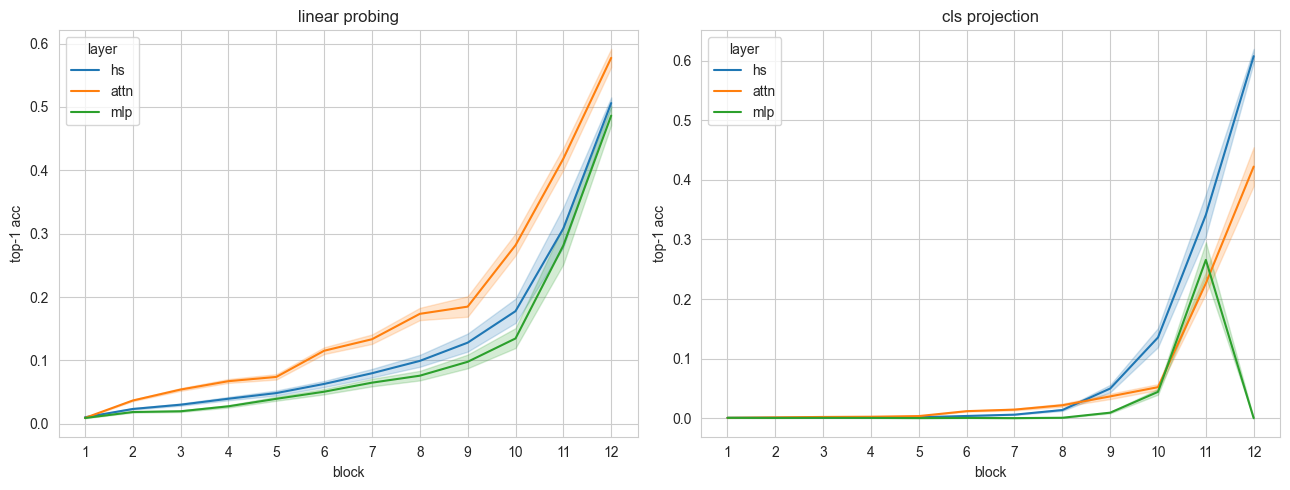

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))

accs = []
for layer in LAYERS:
    file = RES_PATH / 'linear_probing' / layer / 'acc.npy'
    acc = np.load(file)[1:]
    df = pd.DataFrame(acc, columns=['top-1 acc'])
    df['layer'] = layer.split('-')[0]
    df['block'] = int(layer.split('-')[1]) + 1
    accs.append(df)
accs = pd.concat(accs)
sns.lineplot(accs, y='top-1 acc', x='block', hue='layer', ax=axes[0])
axes[0].set_title('linear probing')
axes[0].set_xticks(np.arange(1, 13))

accs = []
for layer in LAYERS:
    block = layer.split('-')[1]
    layer_type = layer.split('-')[0]
    if 'attn' in layer:
        layer = f'hs-attn_{block}'
    elif 'mlp' in layer:
        layer = f'hs-mlp_{block}'
    else:
        layer = f'hs_{block}'
    dec = get_class_embed(
        RES_PATH, DATASET_PATH, 'vit_b_32', layer, 'pos', normalize=False
    )
    dec = dec[:, 1:]
    acc = torch.sum((dec == 0), axis=0) / dec.shape[0]
    df = pd.DataFrame(acc.detach().numpy(), columns=['top-1 acc'])
    df['layer'] = layer_type
    df['block'] = int(block) + 1
    accs.append(df)
accs = pd.concat(accs)
sns.lineplot(accs, y='top-1 acc', x='block', hue='layer', ax=axes[1])
axes[1].set_title('cls projection')
axes[1].set_xticks(np.arange(1, 13))

plt.tight_layout()
plt.show()

## Perturbation experiment

To empirically demonstrate the difference in the insights obtained with both methods, we carried out the following experiment: 

- We trained separate 10-shot linear classifiers on ImageNet for each token position and layer of a VIT-B/32. 
- To test if the information learned by these probes shed light on the categorical decisions taken by the network, we conducted negative and positive perturbation tests. Concretely, we quantified the class identifiability scores obtained from the linear probes for each token, gradually removed the tokens with the least to most identifiable scores (for negative perturbation; vice-versa for positive perturbation), and measured the accuracy of the model with each removal. 
- We compared these results to the positive and negative perturbation results of our framework reported in the previous section.

negative AUC emb: 0.8362941079403841
negative AUC linear: 0.7385176825569436
positive AUC emb: 0.41281954233979434
positive AUC linear: 0.6832468154198523
random AUC: 0.7158862672691159


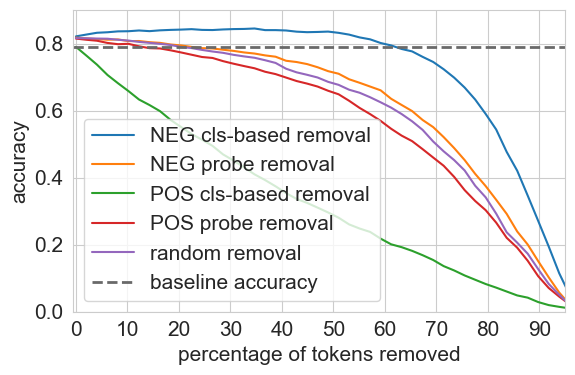

In [17]:
plt.rcParams.update({'font.size': 15})

model_name = 'vit_b_32'

labels = torch.arange(48) / 49 * 100

fig, ax = plt.subplots(figsize=(6,4))

# Plot our method
f = RES_PATH / 'perturbation' / model_name / 'negative_grads.pt'
neg_perturb = torch.load(f, map_location='cpu')
neg_perturb = torch.flip(neg_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=neg_perturb, ax=ax, label='NEG cls-based removal')
print(f'negative AUC emb: {np.sum(neg_perturb) / (np.max(neg_perturb) * 49)}')

# Plot linear probing
f = RES_PATH / 'perturbation' / model_name / 'negative_linear-probe.pt'
linear_perturb = torch.load(f, map_location='cpu')
linear_perturb = torch.flip(linear_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=linear_perturb, ax=ax, label='NEG probe removal')
print(f'negative AUC linear: {np.sum(linear_perturb) / (np.max(linear_perturb) * 49)}')

# Plot our method
f = RES_PATH / 'perturbation' / model_name / 'positive_grads.pt'
neg_perturb = torch.load(f, map_location='cpu')
neg_perturb = torch.flip(neg_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=neg_perturb, ax=ax, label='POS cls-based removal')
print(f'positive AUC emb: {np.sum(neg_perturb) / (np.max(neg_perturb) * 49)}')

# Plot linear probing
f = RES_PATH / 'perturbation' / model_name / 'positive_linear_probe.pt'
linear_perturb = torch.load(f, map_location='cpu')
linear_perturb = torch.flip(linear_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=linear_perturb, ax=ax, label='POS probe removal')
print(f'positive AUC linear: {np.sum(linear_perturb) / (np.max(linear_perturb) * 49)}')

# Plot random perturbation
f = RES_PATH / 'perturbation' / model_name / 'perturb_random.pt'
rand_perturb = torch.mean(torch.load(f, map_location='cpu'), dim=0)
rand_perturb = torch.flip(rand_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=rand_perturb, ax=ax, label='random removal')
print(f'random AUC: {np.sum(rand_perturb) / (np.max(rand_perturb) * 49)}')


ax.hlines(
    xmin=-0.5, xmax=100.5, y=neg_perturb[0], colors='dimgray', linestyles='--', lw=2, 
    label='baseline accuracy'
)
ax.set_xticks(np.arange(0, 100, 10))
ax.set_xlim(-0.5, 95)
ax.set_ylim(0,0.9)
ax.set_xlabel('percentage of tokens removed')
ax.set_ylabel('accuracy')
ax.legend()

plt.tight_layout()
plt.show()

### Plot all

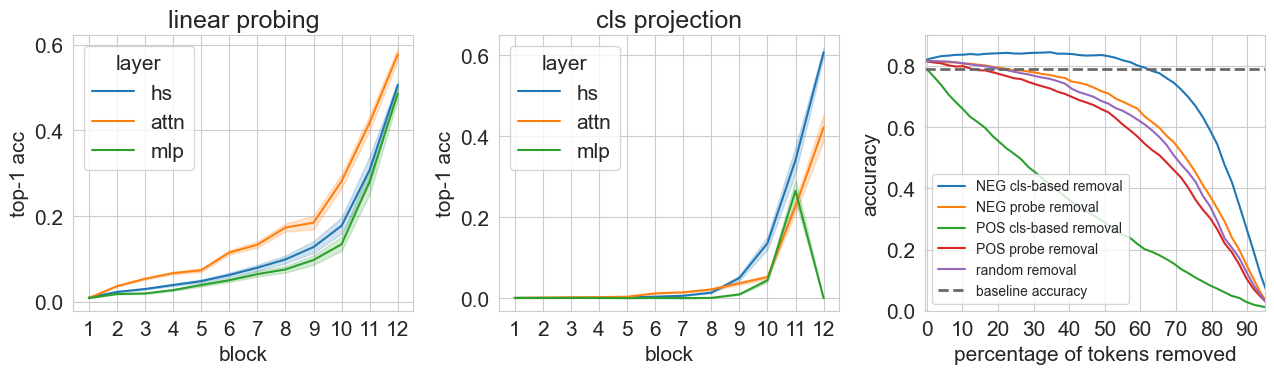

In [19]:
plt.rcParams.update({'font.size': 15})

fig, axes = plt.subplots(ncols=3, figsize=(13, 4))

accs = []
for layer in LAYERS:
    file = RES_PATH / 'linear_probing' / layer / 'acc.npy'
    acc = np.load(file)[1:]
    df = pd.DataFrame(acc, columns=['top-1 acc'])
    df['layer'] = layer.split('-')[0]
    df['block'] = int(layer.split('-')[1]) + 1
    accs.append(df)
accs = pd.concat(accs)
sns.lineplot(accs, y='top-1 acc', x='block', hue='layer', ax=axes[0])
axes[0].set_title('linear probing')
axes[0].set_xticks(np.arange(1, 13))

accs = []
for layer in LAYERS:
    block = layer.split('-')[1]
    layer_type = layer.split('-')[0]
    if 'attn' in layer:
        layer = f'hs-attn_{block}'
    elif 'mlp' in layer:
        layer = f'hs-mlp_{block}'
    else:
        layer = f'hs_{block}'
    dec = get_class_embed(
        RES_PATH, DATASET_PATH, 'vit_b_32', layer, 'pos', normalize=False
    )
    dec = dec[:, 1:]
    acc = torch.sum((dec == 0), axis=0) / dec.shape[0]
    df = pd.DataFrame(acc.detach().numpy(), columns=['top-1 acc'])
    df['layer'] = layer_type
    df['block'] = int(block) + 1
    accs.append(df)
accs = pd.concat(accs)
sns.lineplot(accs, y='top-1 acc', x='block', hue='layer', ax=axes[1])
axes[1].set_title('cls projection')
axes[1].set_xticks(np.arange(1, 13))

## LINEAR PERTURBATION
model_name = 'vit_b_32'

labels = torch.arange(48) / 49 * 100

# Plot our method
f = RES_PATH / 'perturbation' / model_name / 'negative_grads.pt'
neg_perturb = torch.load(f, map_location='cpu')
neg_perturb = torch.flip(neg_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=neg_perturb, ax=axes[2], label='NEG cls-based removal')

# Plot linear probing
f = RES_PATH / 'perturbation' / model_name / 'negative_linear-probe.pt'
linear_perturb = torch.load(f, map_location='cpu')
linear_perturb = torch.flip(linear_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=linear_perturb, ax=axes[2], label='NEG probe removal')

# Plot our method
f = RES_PATH / 'perturbation' / model_name / 'positive_grads.pt'
neg_perturb = torch.load(f, map_location='cpu')
neg_perturb = torch.flip(neg_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=neg_perturb, ax=axes[2], label='POS cls-based removal')

# Plot linear probing
f = RES_PATH / 'perturbation' / model_name / 'positive_linear_probe.pt'
linear_perturb = torch.load(f, map_location='cpu')
linear_perturb = torch.flip(linear_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=linear_perturb, ax=axes[2], label='POS probe removal')

# Plot random perturbation
f = RES_PATH / 'perturbation' / model_name / 'perturb_random.pt'
rand_perturb = torch.mean(torch.load(f, map_location='cpu'), dim=0)
rand_perturb = torch.flip(rand_perturb, dims=(0,)).detach().numpy()
sns.lineplot(x=labels, y=rand_perturb, ax=axes[2], label='random removal')

ax = axes[2]
ax.hlines(
    xmin=-0.5, xmax=100.5, y=neg_perturb[0], colors='dimgray', linestyles='--', lw=2, 
    label='baseline accuracy'
)
ax.set_xticks(np.arange(0, 100, 10))
ax.set_xlim(-0.5, 95)
ax.set_ylim(0,0.9)
ax.set_xlabel('percentage of tokens removed')
ax.set_ylabel('accuracy')
ax.legend(prop={'size': 10})

plt.tight_layout()
f = RES_PATH / 'figures' / f'compare_linear.png'
plt.savefig(f, dpi=300)
plt.show()